<hr>

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ------------------------------------- -- 10.7/11.5 MB 61.0 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 51.6 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tqdm import tqdm  # 진행바 출력용

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 디바이스: {device}")


사용 디바이스: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


c:\Users\user\anaconda3\envs\torch128_py312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\torch128_py312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
def train(model, loader):
    model.train()
    running_loss, correct = 0, 0
    loop = tqdm(loader, desc="Train", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        loop.set_postfix(loss=loss.item())

    return running_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluate", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()

            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    return total_loss / len(loader), correct / len(loader.dataset), preds_all, labels_all


In [7]:
# train_losses, test_losses = [], []
# train_accuracies, test_accuracies = [], []
# best_acc = 0
# patience = 3
# counter = 0
# best_model_path = "saved_models/best_model.pth"

# os.makedirs("saved_models", exist_ok=True)

# for epoch in range(30):
#     print(f"\n📘 Epoch {epoch+1}")

#     train_loss, train_acc = train(model, train_loader)
#     test_loss, test_acc, preds, labels = evaluate(model, test_loader)

#     train_losses.append(train_loss)
#     test_losses.append(test_loss)
#     train_accuracies.append(train_acc)
#     test_accuracies.append(test_acc)

#     print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
#     print(f"Test  Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

#     # 가장 높은 정확도일 경우 저장
#     if test_acc > best_acc:
#         best_acc = test_acc
#         counter = 0
#         torch.save(model.state_dict(), best_model_path)
#         print(f"✅ 모델 저장됨 (정확도: {best_acc:.4f})")
#     else:
#         counter += 1
#         print(f"⏸️ 개선 없음... ({counter}/{patience})")

#         if counter >= patience:
#             print("🛑 조기 종료 조건 만족!")
#             break


In [8]:
import os

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
best_acc = 0
patience = 3
counter = 0

os.makedirs("saved_models", exist_ok=True)

for epoch in range(30):
    print(f"\n📘 Epoch {epoch+1}")

    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc, preds, labels = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Test  Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

    # 가장 높은 정확도일 경우 저장 (덮어쓰기 ❌ → 파일 추가 저장 ⭕️)
    if test_acc > best_acc:
        best_acc = test_acc
        counter = 0
        model_path = f"saved_models/best_model_epoch{epoch+1}_acc{test_acc:.4f}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"✅ 모델 저장됨 → {model_path}")
    else:
        counter += 1
        print(f"⏸️ 개선 없음... ({counter}/{patience})")

        if counter >= patience:
            print("🛑 조기 종료 조건 만족!")
            break



📘 Epoch 1


Train Loss: 0.3119 | Acc: 0.8860
Test  Loss: 0.2361 | Acc: 0.9149
✅ 모델 저장됨 → saved_models/best_model_epoch1_acc0.9149.pth

📘 Epoch 2


Train Loss: 0.2102 | Acc: 0.9233
Test  Loss: 0.2080 | Acc: 0.9273
✅ 모델 저장됨 → saved_models/best_model_epoch2_acc0.9273.pth

📘 Epoch 3


Train Loss: 0.1727 | Acc: 0.9382
Test  Loss: 0.2032 | Acc: 0.9299
✅ 모델 저장됨 → saved_models/best_model_epoch3_acc0.9299.pth

📘 Epoch 4


Train Loss: 0.1487 | Acc: 0.9460
Test  Loss: 0.2337 | Acc: 0.9229
⏸️ 개선 없음... (1/3)

📘 Epoch 5


Train Loss: 0.1206 | Acc: 0.9565
Test  Loss: 0.1849 | Acc: 0.9385
✅ 모델 저장됨 → saved_models/best_model_epoch5_acc0.9385.pth

📘 Epoch 6


KeyboardInterrupt: 

In [9]:
# model.load_state_dict(torch.load(best_model_path))
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"✅ 저장된 최고 모델 로드 완료 (정확도: {best_acc:.4f})")


✅ 저장된 최고 모델 로드 완료 (정확도: 0.9385)


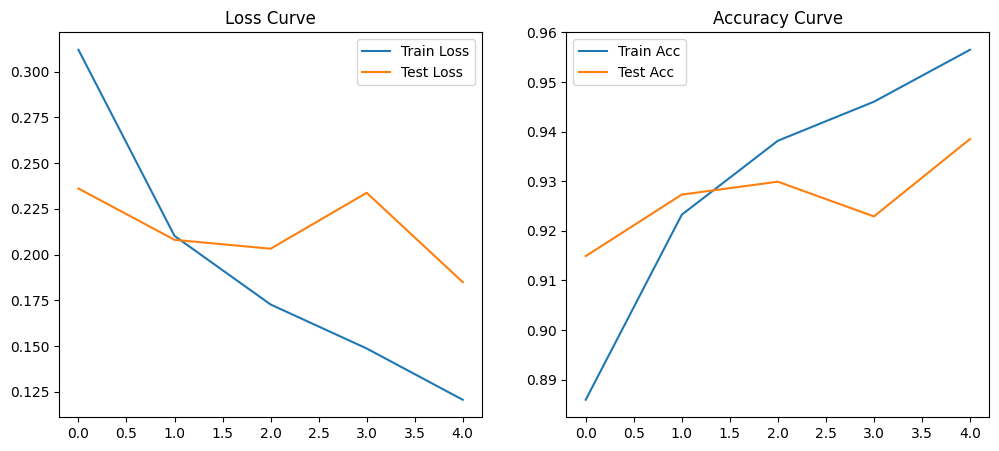

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(test_accuracies, label="Test Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


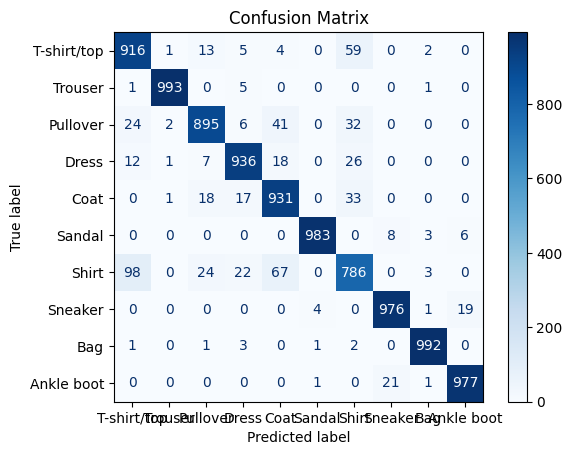

In [11]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [12]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        output[0, class_idx].backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.nn.functional.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam


c:\Users\user\anaconda3\envs\torch128_py312\Lib\site-packages\torch\nn\modules\module.py:1831: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


FileNotFoundError: [Errno 2] No such file or directory: 'gradcam/sample_gradcam.png'

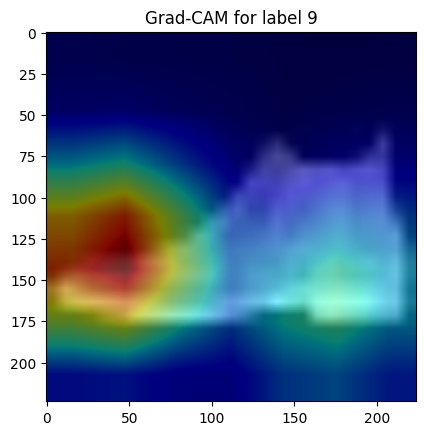

In [13]:
gradcam = GradCAM(model, model.layer4[1].conv2)

images, labels = next(iter(test_loader))
img = images[0].unsqueeze(0).to(device)
cam = gradcam.generate(img)

original = images[0].squeeze().numpy()
plt.imshow(original, cmap="gray")
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.title(f"Grad-CAM for label {labels[0]}")
plt.savefig("gradcam/sample_gradcam.png")
plt.show()
